<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LassoCV


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [4]:
# Load the data
house = pd.read_csv('./housing.csv')

In [8]:
# looking at dataframe
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
house.shape

(1460, 81)

In [6]:
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

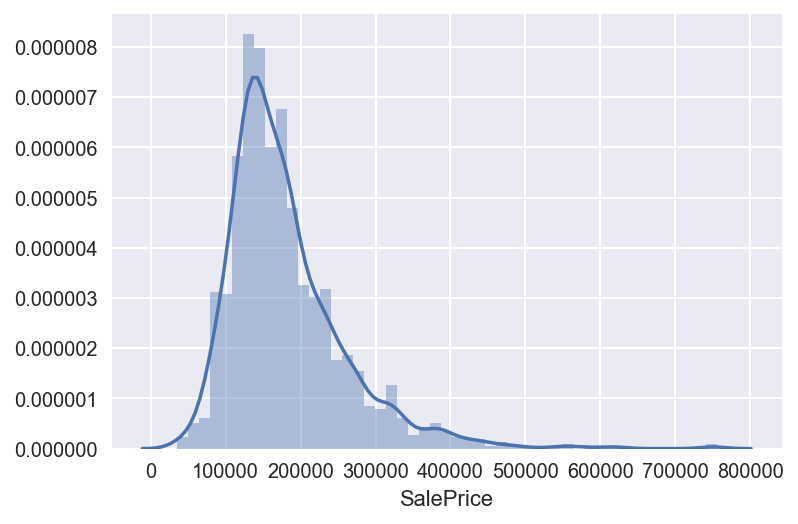

In [7]:
sns.distplot(house.SalePrice)
# seems a bit skewed, try log of sales price to normalise.

In [8]:
house['logSalePrice'] = np.log(house.SalePrice)

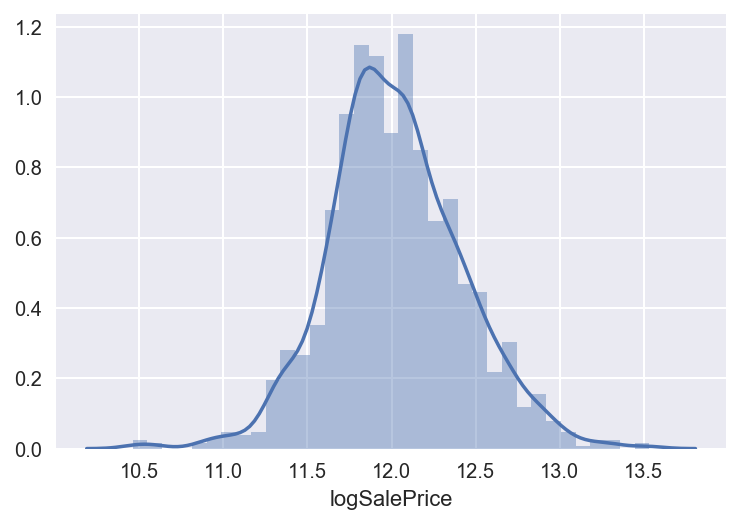

In [9]:
sns.distplot(house.logSalePrice)
# this more normally distributed, use this for future prediction. 
# My university stats was not entirely in vain...

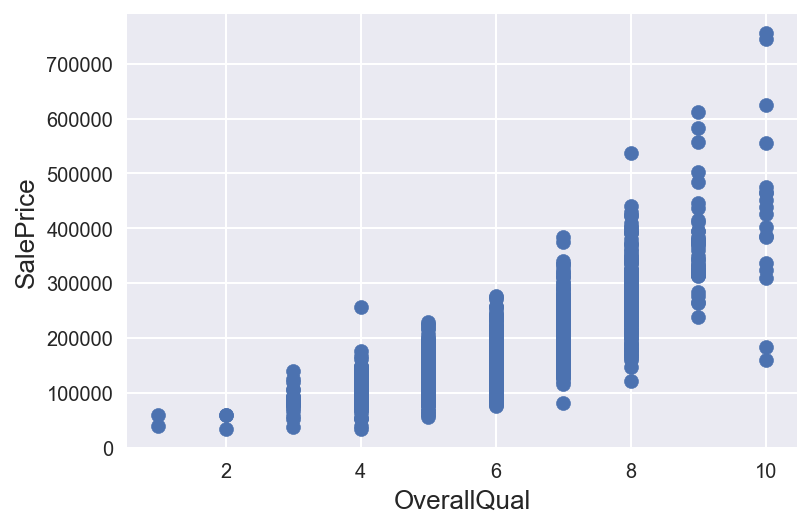

In [10]:
# Let's throw some graphs about.

fig, ax = plt.subplots()
ax.scatter(x = house['OverallQual'], y = house['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

# not that useful of a plot.

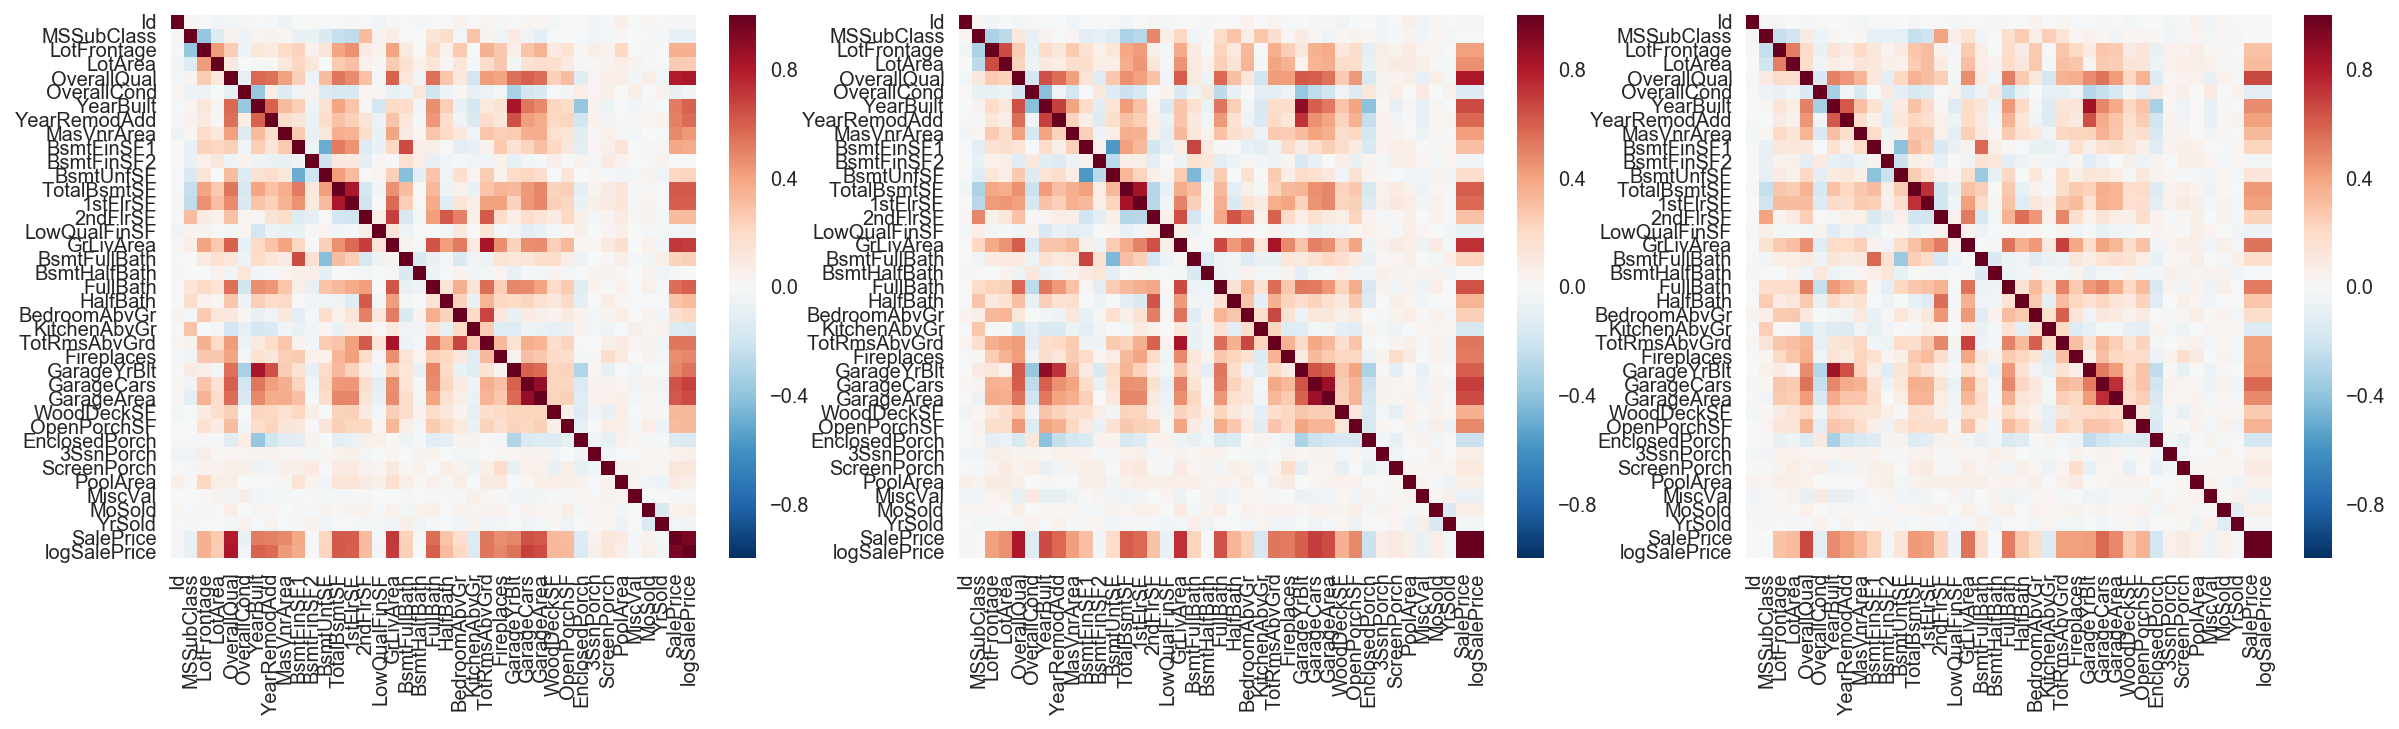

In [11]:
(fig, axes) = plt.subplots(ncols = 3)
fig.set_size_inches(20,5)
sns.heatmap(house.corr(), ax=axes[0])
sns.heatmap(house.corr('spearman'), ax=axes[1])
sns.heatmap(house.corr('kendall'), ax=axes[2])

# some correlations exist, no huge differences between different correlation types.

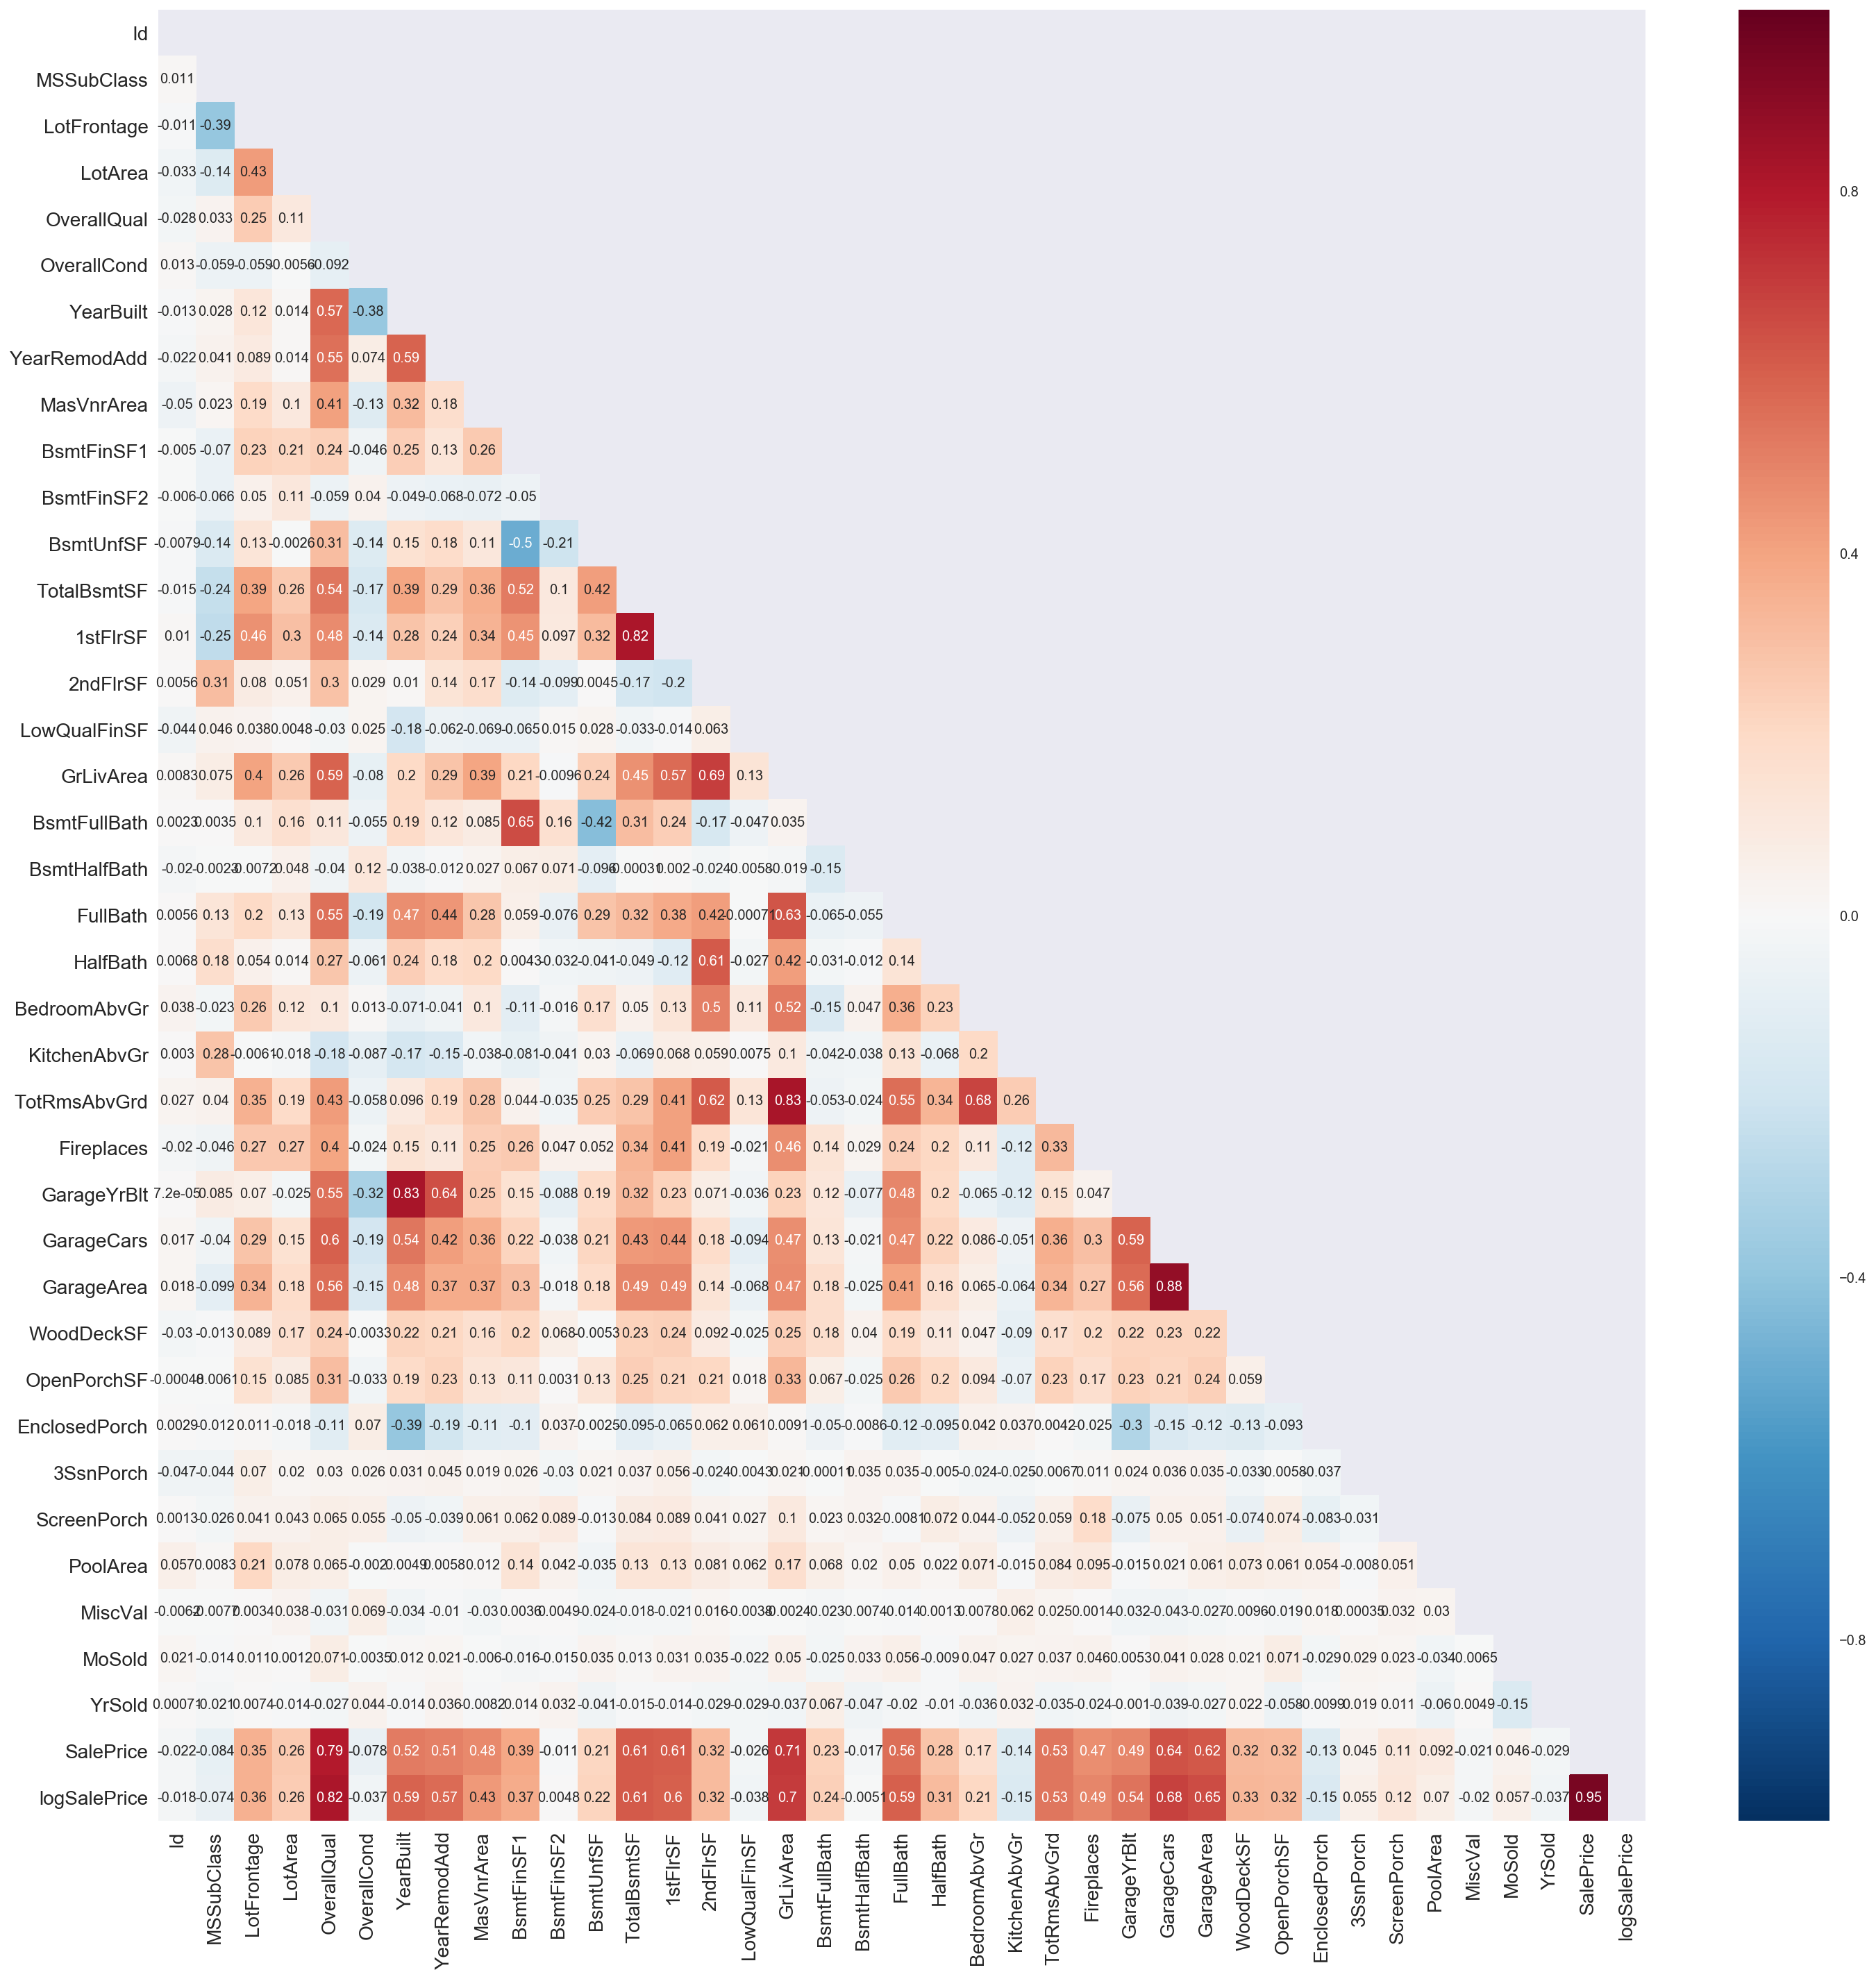

In [12]:
# above is a little difficult to view correlation scores, using template from seaborn library

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(24,24))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(house.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(house.corr(), mask=mask, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [13]:
# this took forever, not that useful.
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# sns.pairplot(house[cols], size = 2.5, hue='SalePrice')
# plt.show();


In [14]:
house.corr().SalePrice.sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
logSalePrice     0.948374
SalePrice   

In [15]:
house.corr('kendall').SalePrice.sort_values()

EnclosedPorch   -0.172094
KitchenAbvGr    -0.134718
OverallCond     -0.103492
LowQualFinSF    -0.055308
MiscVal         -0.050917
BsmtFinSF2      -0.030710
YrSold          -0.021796
Id              -0.012030
BsmtHalfBath    -0.009962
MSSubClass      -0.003979
PoolArea         0.047800
MoSold           0.049471
3SsnPorch        0.053478
ScreenPorch      0.080654
BsmtUnfSF        0.127457
BsmtFullBath     0.183182
BedroomAbvGr     0.185607
BsmtFinSF1       0.220879
2ndFlrSF         0.232497
WoodDeckSF       0.260349
HalfBath         0.278698
LotFrontage      0.290361
LotArea          0.314174
MasVnrArea       0.321250
OpenPorchSF      0.350161
TotRmsAbvGrd     0.410168
1stFlrSF         0.411556
Fireplaces       0.412829
YearRemodAdd     0.412955
GarageYrBlt      0.420842
TotalBsmtSF      0.435018
YearBuilt        0.470960
GarageArea       0.478146
FullBath         0.518693
GrLivArea        0.543942
GarageCars       0.572168
OverallQual      0.669660
SalePrice        1.000000
logSalePrice

### let's actually look at addressing the brief

In [16]:
# Focus is on residential houses, 
house['MSZoning'].value_counts()


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [17]:
# Only keep the RL, RM, FV, RH.  Not sure what a Floating Village Residential is
# but has "Residential" in it.  C (all) is Commercial.

house = house[house.MSZoning.isin(['RL', 'RM', 'FV', 'RH'])]

In [18]:
# how many null values?

nulls = house.isnull().sum()[house.isnull().sum() > 0]

# A lot of nulls denote that the feature is not present.

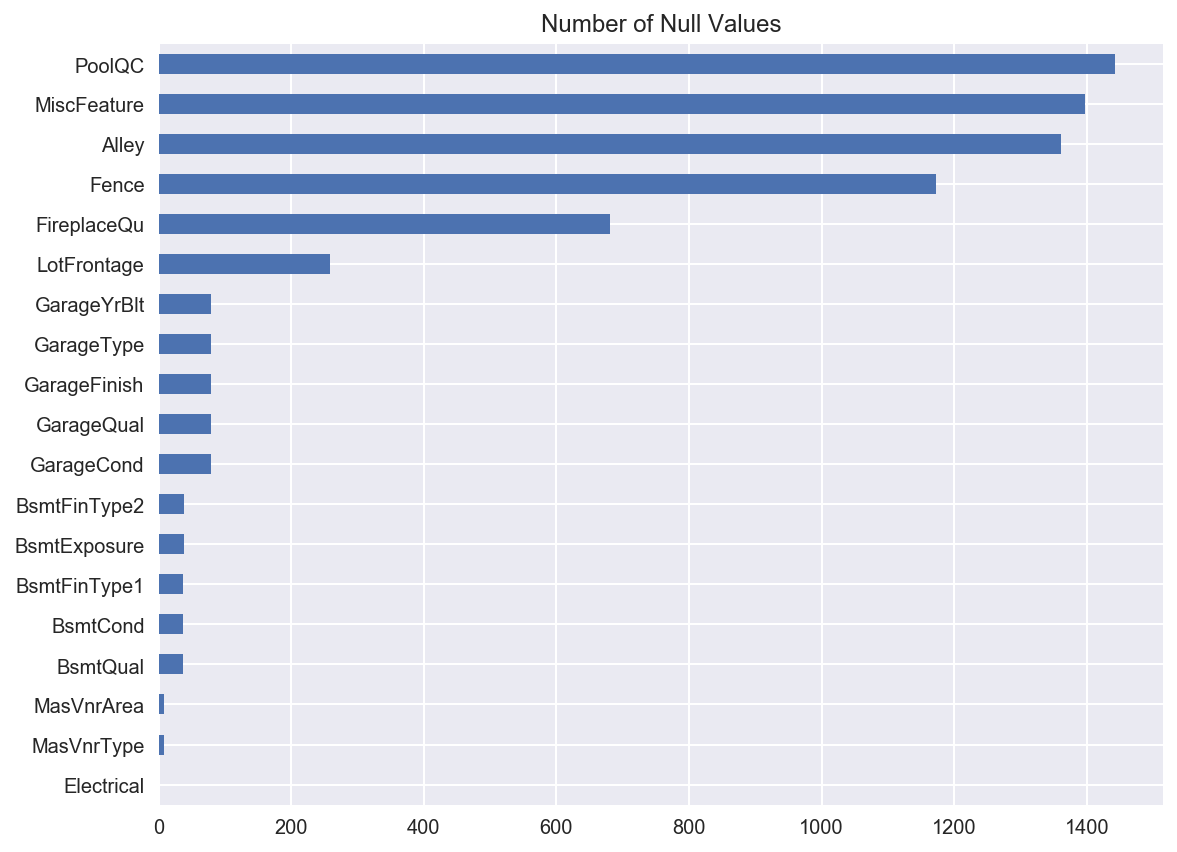

In [19]:

nulls.sort_values().plot.barh(title = "Number of Null Values", figsize = (9,7))
 
# some features have a lot of null values, four of which have > 1000.
# let's have a closer look

In [20]:
print house.PoolQC.value_counts()
print house.MiscFeature.value_counts()
print house.Alley.value_counts()
print house.Fence.value_counts()

# let's keep these for now 

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
Shed    47
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64
Grvl    50
Pave    39
Name: Alley, dtype: int64
MnPrv    155
GdPrv     59
GdWo      53
MnWw      11
Name: Fence, dtype: int64


In [21]:
# what is ID column.
house.Id

0          1
1          2
2          3
3          4
4          5
5          6
6          7
7          8
8          9
9         10
10        11
11        12
12        13
13        14
14        15
15        16
16        17
17        18
18        19
19        20
20        21
21        22
22        23
23        24
24        25
25        26
26        27
27        28
28        29
29        30
        ... 
1430    1431
1431    1432
1432    1433
1433    1434
1434    1435
1435    1436
1436    1437
1437    1438
1438    1439
1439    1440
1440    1441
1441    1442
1442    1443
1443    1444
1444    1445
1445    1446
1446    1447
1447    1448
1448    1449
1449    1450
1450    1451
1451    1452
1452    1453
1453    1454
1454    1455
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1450, dtype: int64

In [22]:
# let's drop Id.
house = house.drop('Id', axis=1)
house.shape

(1450, 81)

In [23]:
# Data can be split into continuous and categorical variables (to be addressed shortly)
# MSSubClass seems to be set up as a scale which could throw things off.
# MSSubClass also seem to overlap with BldgType & HouseStyle

house.MSSubClass.value_counts()

20     534
60     299
50     140
120     87
30      67
160     63
70      59
80      58
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [24]:
# I'll try leaving everything in and letting the machine tell me what's important.
# But first, remap with field descriptors in lieu of numbers.

MSSubClass_Dict = {20: '1-STORY_1946',
                   30: '1-STORY_1945',
                   40: '1STORY_ATTIC',
                   45: '1.5STORY_UNFIN',
                   50: '1.5STORY_FIN',
                   60: '2STORY_1946_N',
                   70: '2STORY_1945_O',
                   75: '2.5STORY',
                   80: 'SPLITLEVEL',
                   85: 'SPLITFOYER',
                   90: 'DUPLEX',
                   120: '1STORY_PUD',
                   150: '1.5STORY_PUD',
                   160: '2STORY_PUD',
                   180: 'MULTILEVEL_PUD',
                   190: '2FAMILY_CONV'}


house.MSSubClass.replace(MSSubClass_Dict, inplace=True)

In [25]:
house.MSSubClass.value_counts()

1-STORY_1946      534
2STORY_1946_N     299
1.5STORY_FIN      140
1STORY_PUD         87
1-STORY_1945       67
2STORY_PUD         63
2STORY_1945_O      59
SPLITLEVEL         58
DUPLEX             52
2FAMILY_CONV       29
SPLITFOYER         20
2.5STORY           16
1.5STORY_UNFIN     12
MULTILEVEL_PUD     10
1STORY_ATTIC        4
Name: MSSubClass, dtype: int64

In [26]:
# convert object null values to 'none' as per data description

for col in house.columns:
    if house[col].dtype == 'object':
        house[col].fillna(value = 'None', inplace=True)

In [27]:
# impute median for floats.

for col in house.columns:
    if house[col].dtype != 'object':
        house[col].fillna(value = house[col].median(), inplace=True)

In [28]:
# check for nulls again
house.isnull().sum()[house.isnull().sum() > 0]



Series([], dtype: int64)

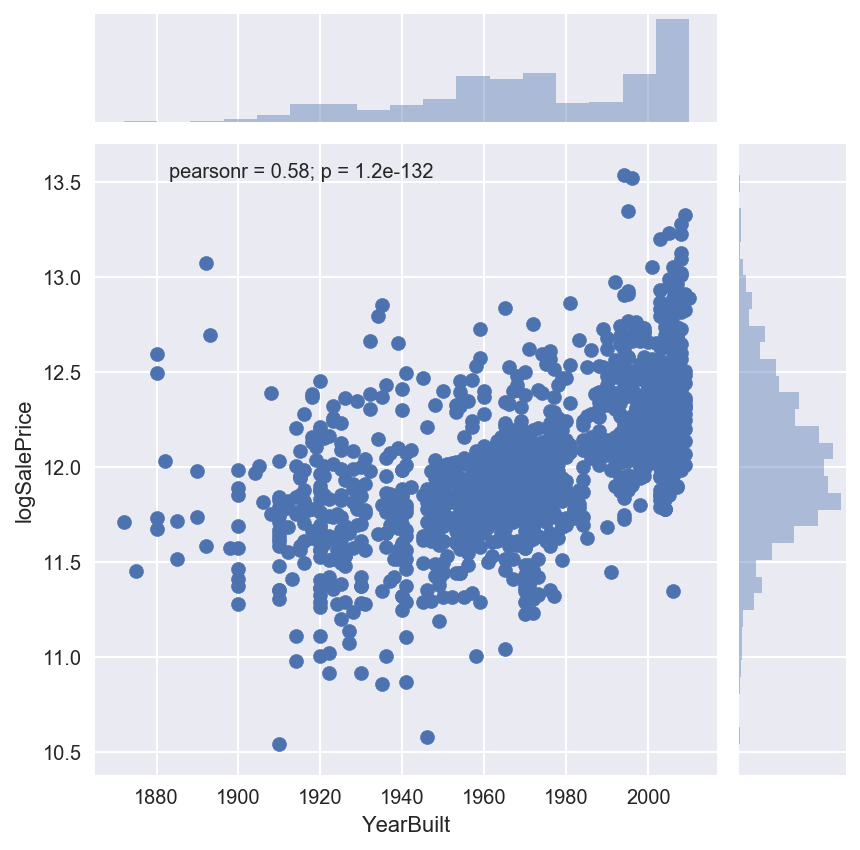

In [29]:
# Looking through the variables for potential features to be added

# starting with age.

sns.jointplot(house.YearBuilt, house.logSalePrice)

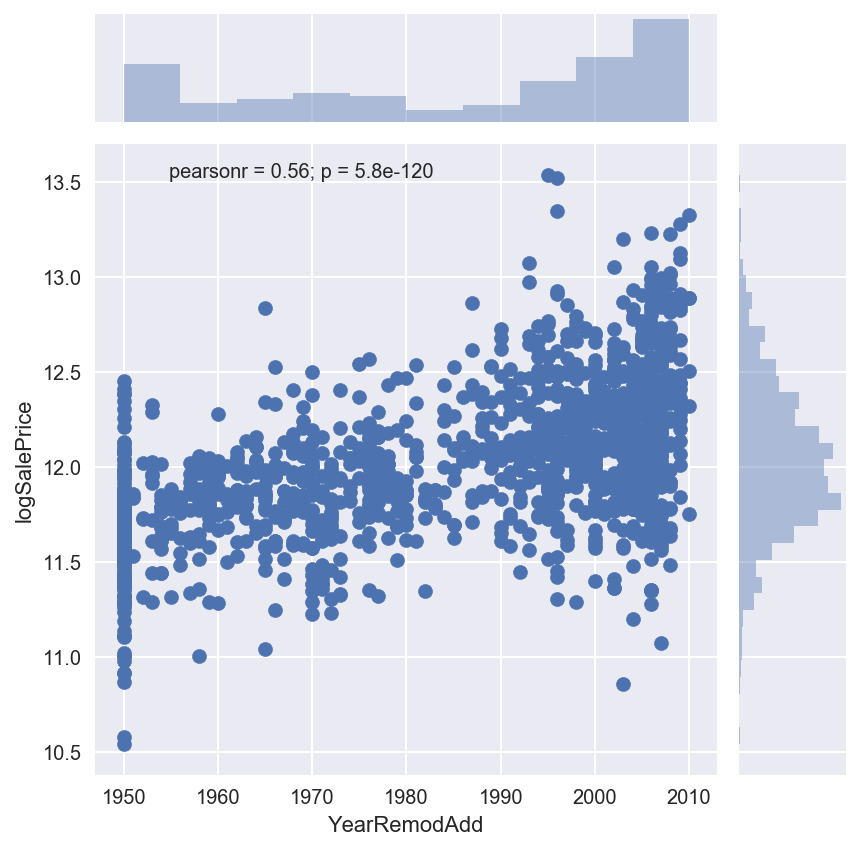

In [30]:
sns.jointplot(house.YearRemodAdd, house.logSalePrice)

In [31]:
# Create a new feature: age of house when sold.

house['AgeHouseWhenSold'] = (house.YrSold + (house.MoSold)/12) - house.YearBuilt

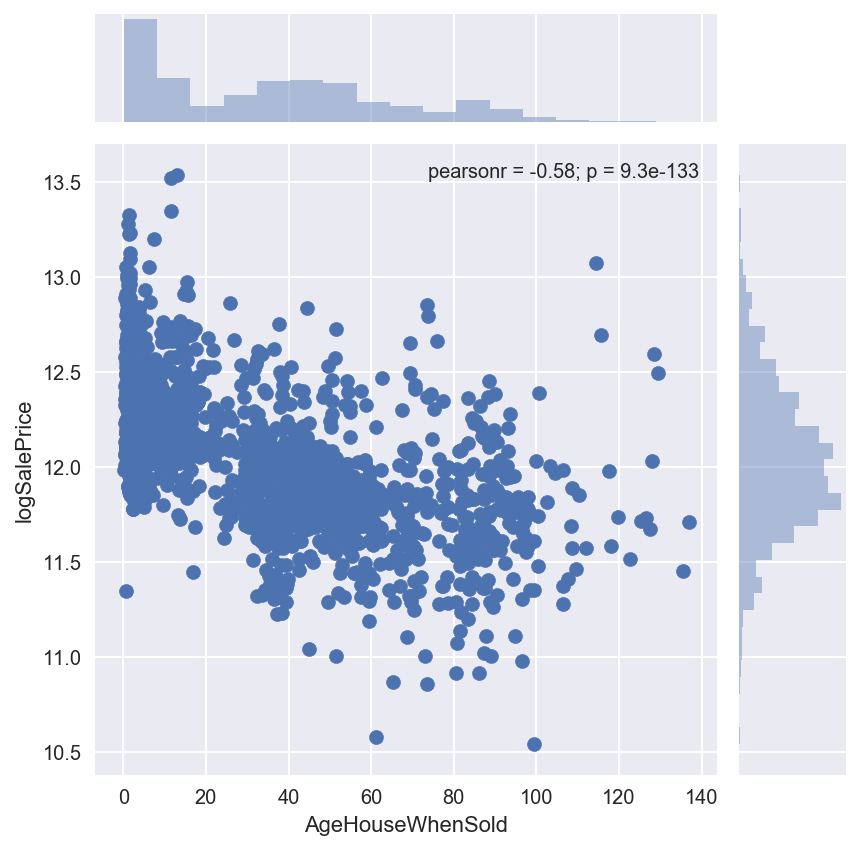

In [32]:
sns.jointplot(house.AgeHouseWhenSold, house.logSalePrice)

# not too bad, perhaps a worthwhile addition to the model.

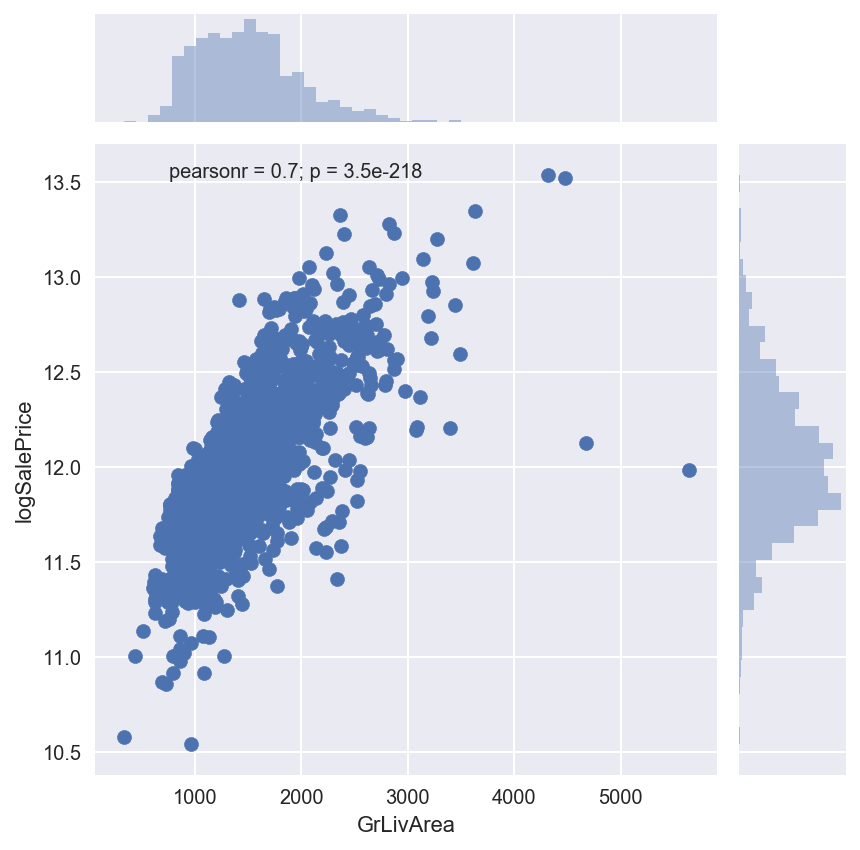

In [33]:
sns.jointplot(house.GrLivArea, house.logSalePrice)
# clearly important, let's create new variables for usable area.

In [34]:
# what's with all the basements?

house[['TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']]

# TotalBSMSF = sum of 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'

,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
0,856,706,0,150
1,1262,978,0,284
2,920,486,0,434
3,756,216,0,540
4,1145,655,0,490
5,796,732,0,64
6,1686,1369,0,317
7,1107,859,32,216
8,952,0,0,952
9,991,851,0,140


In [35]:
# creating some new features for Basement and Usable Areas

house['BsmtFin_TotalSF'] = house.BsmtFinSF1 - house.BsmtFinSF2 
house['UsableSF'] = house.GrLivArea + house.BsmtFin_TotalSF - house.LowQualFinSF

In [36]:
# create feature for bathrooms
# played with the multipliers for half bath and basement and settled on the below (based on the corr values)

house['Baths_Total'] = (house.BsmtFullBath + house.BsmtHalfBath*0.5)/2 + house.FullBath + house.HalfBath*0.5

In [37]:
# outdoor spaces

house['Outdoor_Total'] = house.WoodDeckSF + house.OpenPorchSF + house.EnclosedPorch + house['3SsnPorch'] + house.ScreenPorch 

In [38]:
# age of garage when sold

house['AgeGarageWhenSold'] = house.YrSold - house.GarageYrBlt

In [39]:
house['TotalArea'] = house.TotalBsmtSF + house.GrLivArea + house.GarageArea + house.Outdoor_Total

In [40]:
house.corr('spearman').logSalePrice.sort_values(ascending = False)

# some of these new features aren't spectacular...

logSalePrice         1.000000
SalePrice            1.000000
TotalArea            0.847850
OverallQual          0.807320
Baths_Total          0.733702
GrLivArea            0.732134
UsableSF             0.694241
GarageCars           0.693763
GarageArea           0.654254
YearBuilt            0.648573
FullBath             0.633056
TotalBsmtSF          0.600416
1stFlrSF             0.572587
YearRemodAdd         0.565743
GarageYrBlt          0.564579
TotRmsAbvGrd         0.533663
Fireplaces           0.515363
OpenPorchSF          0.480353
LotArea              0.458966
Outdoor_Total        0.428112
MasVnrArea           0.412052
LotFrontage          0.385685
WoodDeckSF           0.350261
HalfBath             0.340353
BsmtFinSF1           0.298611
2ndFlrSF             0.295259
BsmtFin_TotalSF      0.294336
BedroomAbvGr         0.228222
BsmtFullBath         0.221016
BsmtUnfSF            0.188966
ScreenPorch          0.099899
MoSold               0.075650
3SsnPorch            0.064586
PoolArea  

In [41]:
house[['GrLivArea', '1stFlrSF', '2ndFlrSF']].sample(10)

# GrLiveArea = 1stFlrSF + 2ndFlrSF, ok leave as is.

,GrLivArea,1stFlrSF,2ndFlrSF
1362,1738,1281,457
211,1212,1212,0
1449,630,630,0
282,1314,1314,0
381,1301,1301,0
201,1279,1279,0
628,2080,1040,1040
627,1520,1520,0
1118,1601,1021,580
1388,1746,1746,0


In [42]:
# check by age, test data will be 2010.
house.YrSold.value_counts()

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

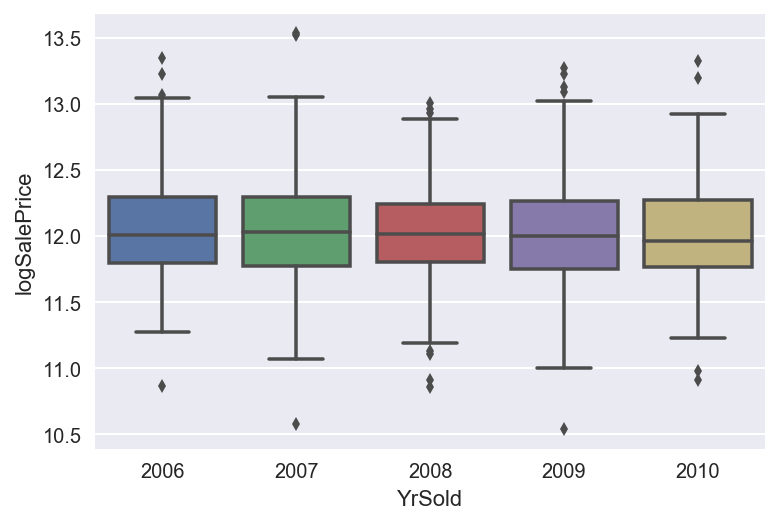

In [43]:
sns.boxplot(house.YrSold, house.logSalePrice)
# some outliers, no strong variation otherwise.

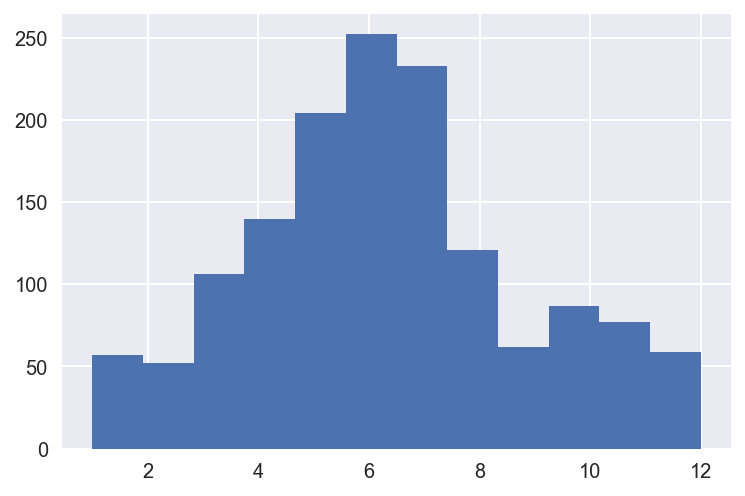

In [44]:
house.MoSold.hist(bins=12)
# The summer months are more active, but joint plot below shows no real bearing on SalePrice.

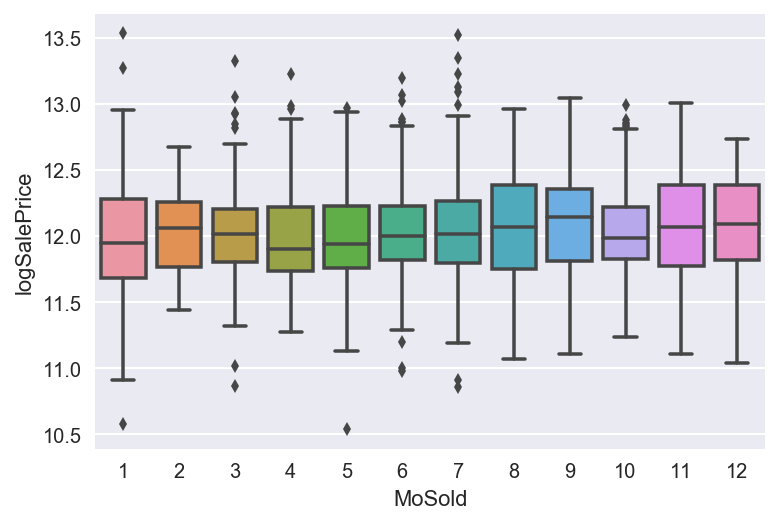

In [45]:
sns.boxplot(house.MoSold, house.logSalePrice)
# a bit more interesting vs. year plot.

In [46]:
# Creating list of changeable_features, so we can drop these from the model.


changeable_features = ['OverallQual', 
                       'OverallCond', 
                       'RoofStyle', 
                       'RoofMatl', 
                       'Exterior1st', 
                       'Exterior2nd',
                       'MasVnrType', 
                       'MasVnrArea', 
                       'ExterQual', 
                       'ExterCond', 
                       'BsmtQual', 
                       'BsmtCond', 
                       'BsmtFinType1',
                       'BsmtFinType2', 
                       'Heating', 
                       'HeatingQC', 
                       'CentralAir', 
                       'Electrical',
                       'LowQualFinSF',
                       'KitchenQual',
                       'Fireplaces', 
                       'FireplaceQu',
                       'GarageQual',
                       'GarageCond',
                       'GarageFinish',
                       'PavedDrive', 
                       'PoolQC', 
                       'Fence', 
                       'MiscFeature', 
                       'MiscVal'
                      ]

In [47]:
# make new dataframe for only fixed characteristics (not the most efficient way but it works)

house_fixed = []
for y in house.columns:
    if y not in changeable_features:
        house_fixed.append(y)

In [48]:
house[house_fixed]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,SalePrice,logSalePrice,AgeHouseWhenSold,BsmtFin_TotalSF,UsableSF,Baths_Total,Outdoor_Total,AgeGarageWhenSold,TotalArea
0,2STORY_1946_N,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,Normal,208500,12.247694,5.166667,706,2416,3.00,61,5.0,3175
1,1-STORY_1946,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,Normal,181500,12.109011,31.416667,978,2240,2.25,298,31.0,3282
2,2STORY_1946_N,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,Normal,223500,12.317167,7.750000,486,2272,3.00,42,7.0,3356
3,2STORY_1945_O,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,Abnorml,140000,11.849398,91.166667,216,1933,1.50,307,8.0,3422
4,2STORY_1946_N,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,Normal,250000,12.429216,9.000000,655,2853,3.00,276,8.0,4455
5,1.5STORY_FIN,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,...,Normal,143000,11.870600,16.833333,732,2094,2.00,390,16.0,3028
6,1-STORY_1946,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,...,Normal,307000,12.634603,3.666667,1369,3063,2.50,312,3.0,4328
7,2STORY_1946_N,RL,70.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,Normal,200000,12.206073,36.916667,827,2917,3.00,667,36.0,4348
8,1.5STORY_FIN,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,...,Abnorml,129900,11.774520,77.333333,0,1774,2.00,295,77.0,3489
9,2FAMILY_CONV,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,...,Normal,118000,11.678440,69.083333,851,1928,1.50,4,69.0,2277


### Regression time

In [49]:
# prepping for regressions, create dummies, and setting X & y.

house_fixed_dummies = pd.get_dummies(house[house_fixed])
house_fixed_dummies.shape

(1450, 175)

In [50]:
# Create Pre & Post 2010 data

X_pre2010 = house_fixed_dummies[house_fixed_dummies.YrSold < 2010].copy()
X_2010 = house_fixed_dummies[house_fixed_dummies.YrSold == 2010].copy()

In [51]:
X_pre2010.shape, X_2010.shape

((1278, 175), (172, 175))

In [52]:
# Create the targets.

Y_pre2010 = X_pre2010.logSalePrice
Y_2010 = X_2010.logSalePrice

In [53]:
Y_pre2010.shape, Y_2010.shape

((1278,), (172,))

In [54]:
# drop SalePrice & logSalePrice from test data.

X_pre2010.drop(['SalePrice', 'logSalePrice'], axis=1, inplace = True)
X_2010.drop(['SalePrice', 'logSalePrice'], axis=1, inplace = True)


In [55]:
X_pre2010.shape, X_2010.shape

((1278, 173), (172, 173))

In [56]:
# Standardise test data

import sklearn.preprocessing
scaler = sklearn.preprocessing.StandardScaler()

fitModel = scaler.fit(X_pre2010)
Xs_pre2010 = fitModel.transform(X_pre2010)
Xs_2010 = fitModel.transform(X_2010)

In [57]:
# starting with a lasso due to width of dataframe w, dummies.

In [58]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_pre2010, Y_pre2010)

print optimal_lasso.alpha_


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00513590001452


..................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


In [59]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_pre2010, Y_pre2010, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.89876244  0.90810494  0.89159824  0.7822405   0.88052273  0.80394331
  0.87694951  0.85496317  0.46973229  0.85439942]
0.822121655909


In [60]:
lasso.fit(Xs_pre2010, Y_pre2010)

Lasso(alpha=0.005135900014515124, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
lasso_coefs = pd.DataFrame({'variable':X_pre2010.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs[lasso.coef_ != 0]

# some of these are still remarkably close to 0.


,abs_coef,coef,variable
35,0.063886,0.063886,TotalArea
19,0.048114,0.048114,GarageCars
100,0.023175,0.023175,Neighborhood_StoneBr
150,0.020804,0.020804,Functional_Typ
85,0.019585,-0.019585,Neighborhood_Edwards
140,0.015305,0.015305,BsmtExposure_Gd
93,0.014674,0.014674,Neighborhood_NoRidge
33,0.013622,0.013622,Outdoor_Total
11,0.010900,0.010900,BsmtFullBath
143,0.010858,-0.010858,BsmtExposure_None


In [62]:
lasso_coefs[lasso.coef_ > 0.0001].shape

# 79 retained is generous compared to the 41 here.

(36, 3)

In [63]:
print 'Percent of variables zeroed out:', np.sum((lasso.coef_ == 0))/float(Xs_pre2010.shape[1])


Percent of variables zeroed out: 0.601156069364


In [64]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

l1_ratios = np.linspace(0.005, 0.05, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs_pre2010, Y_pre2010)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.315926177631
0.00875


...........................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   15.9s finished


In [65]:
# l1_ratio is close to 0, perhaps a Ridge is more appropriate.

In [66]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_pre2010, Y_pre2010, cv=10)

print enet_scores
print np.mean(enet_scores)

[ 0.90366074  0.8871284   0.88915692  0.78491407  0.87378376  0.8412383
  0.87276601  0.86395145  0.54896946  0.85845373]
0.832402283987


In [67]:
# comparable to Lasso.

In [68]:
# Let's try Ridge

In [69]:
from sklearn.linear_model import Ridge, RidgeCV

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_pre2010, Y_pre2010)

print optimal_ridge.alpha_

651.733960488


In [70]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_pre2010, Y_pre2010, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.89765237  0.87062088  0.88597202  0.77199997  0.86986912  0.83786763
  0.86749228  0.86317304  0.56656684  0.85847257]
0.828968672232


In [71]:
print "Lasso " + str(np.mean(lasso_scores))
print "E-Net " + str(np.mean(enet_scores))
print "Ridge " + str(np.mean(ridge_scores))
# all performed comparably well, slight advantage to Elastic Net here.

Lasso 0.822121655909
E-Net 0.832402283987
Ridge 0.828968672232


In [72]:
# Trying on test data

best_lasso = Lasso(alpha=optimal_lasso.alpha_)
best_lasso.fit(Xs_pre2010, Y_pre2010)
best_lasso.score(Xs_2010, Y_2010)

0.908723520396849

In [73]:
best_ridge = Ridge(alpha=optimal_ridge.alpha_)
best_ridge.fit(Xs_pre2010, Y_pre2010)
best_ridge.score(Xs_2010, Y_2010)

0.90072918447934747

In [74]:
best_enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
best_enet.fit(Xs_pre2010, Y_pre2010)
best_enet.score(Xs_2010, Y_2010)

0.90375478610014426

In [75]:
# Lasso appears to have performed the best on the test data
# though all have performed comparably well, with only ~0.7% difference in the variance in Sale Price being explained.

# Let's call it now, and continue tinkering if time allows.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [76]:
train_res = (Y_pre2010) - (best_lasso.predict(Xs_pre2010))
test_res = (Y_2010) - (best_lasso.predict(Xs_2010))

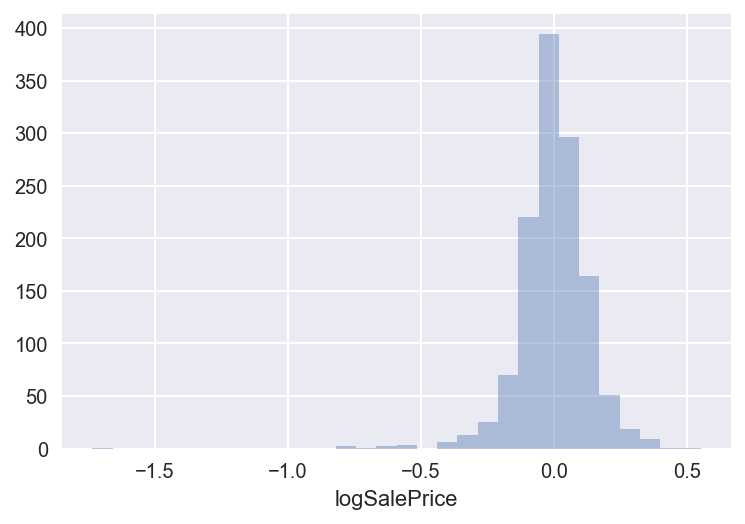

In [77]:
sns.distplot(train_res, bins=30, kde=False)

# There's a value well off to the left as possible outlier.
# These are log transformed values here.

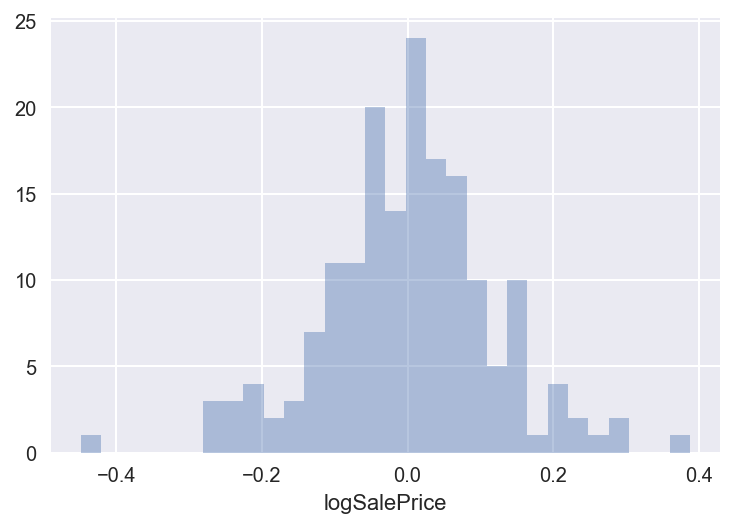

In [78]:
sns.distplot(test_res, bins=30, kde=False)

In [79]:
train_res.describe()

# the minimum value is well off..

count    1.278000e+03
mean    -1.820835e-16
std      1.348519e-01
min     -1.735809e+00
25%     -6.183408e-02
50%      7.230199e-04
75%      7.085484e-02
max      5.539142e-01
Name: logSalePrice, dtype: float64

In [80]:
# Residuals in $ value to make it easier to intepret outputs.

train_res = np.exp(Y_pre2010) - np.exp(best_lasso.predict(Xs_pre2010))
test_res = np.exp(Y_2010) - np.exp(best_lasso.predict(Xs_2010))

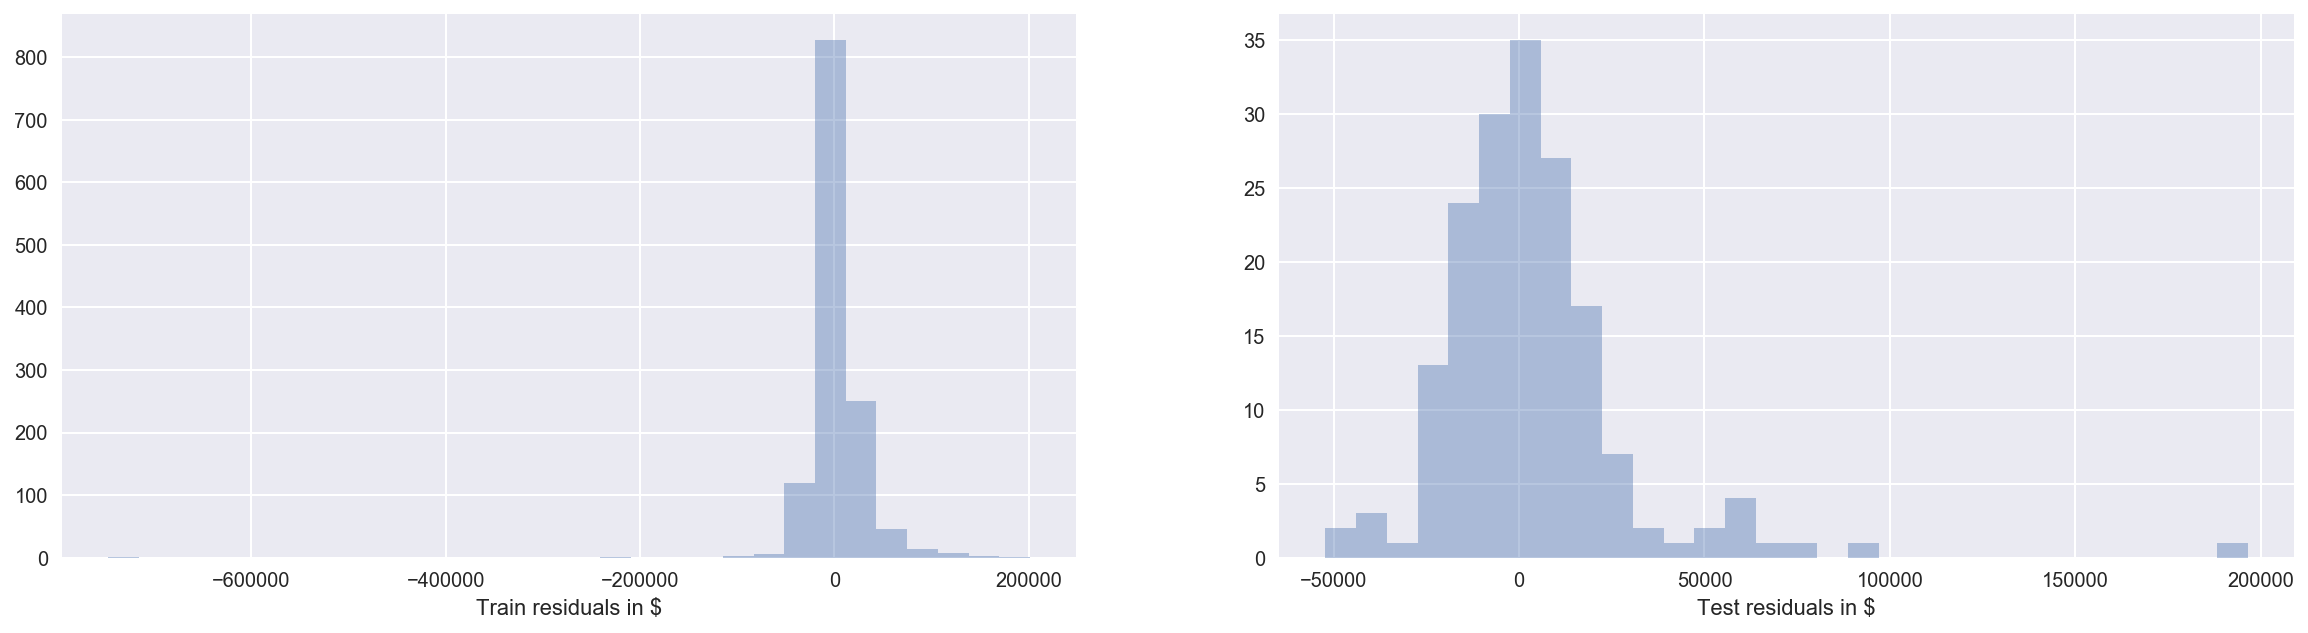

In [81]:
(fig, ax) = plt.subplots(ncols = 2)
fig.set_size_inches(20,5)
sns.distplot(train_res, bins=30, kde=False, axlabel = 'Train residuals in $', ax=ax[0])
sns.distplot(test_res, bins=30, kde=False, axlabel = 'Test residuals in $', ax=ax[1])

# Test residuals aren't too bad, but the left lying outliers in Train needs addressing.

In [83]:
# let's try windsoring
# is this even needed..?
import scipy.stats
train_res_w = scipy.stats.mstats.winsorize(train_res, limits=0.007)

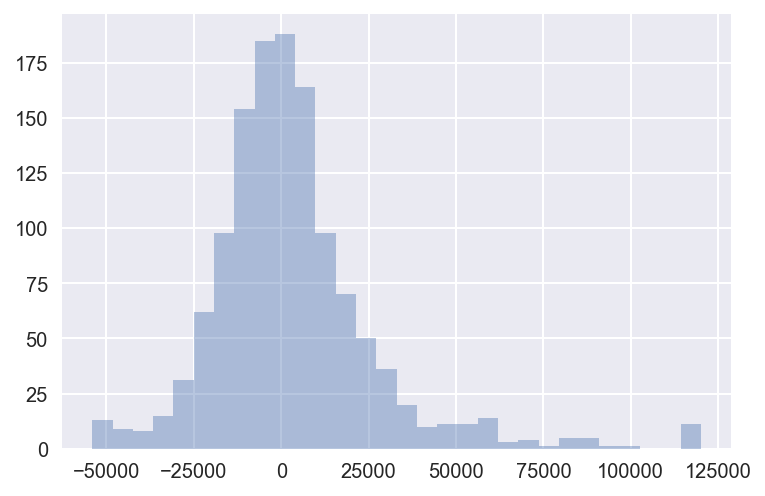

In [84]:
sns.distplot(train_res_w, bins=30, kde=False)
# outliers have been reigned in.

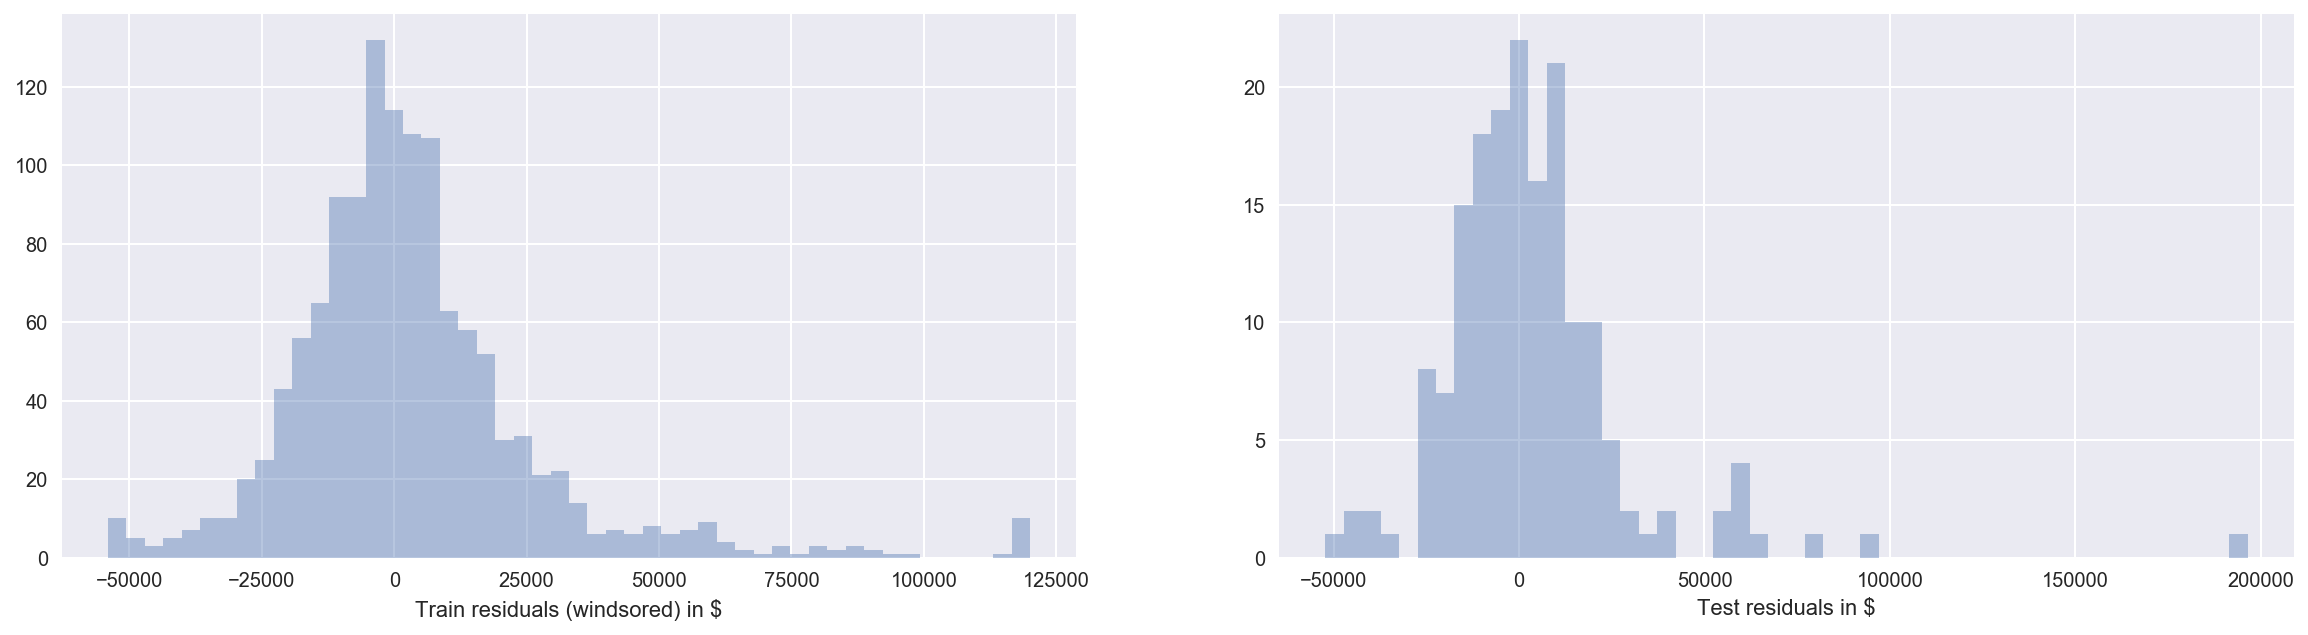

In [85]:
(fig, ax) = plt.subplots(ncols = 2)
fig.set_size_inches(20,5)
sns.distplot(train_res_w, bins=50, kde=False, axlabel = 'Train residuals (windsored) in $', ax=ax[0])
sns.distplot(test_res, bins=50, kde=False, axlabel = 'Test residuals in $', ax=ax[1])
# train and test residuals seem fairly consistent

In [86]:
# review residuals with our changeable_features defined previously.
changeable_features

['OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'Fireplaces',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'GarageFinish',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal']

In [87]:
# make new dataframe for only changeable characterstics
renovate = house[changeable_features].copy()

print renovate.columns
print renovate.shape

Index([u'OverallQual', u'OverallCond', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'BsmtQual', u'BsmtCond', u'BsmtFinType1',
       u'BsmtFinType2', u'Heating', u'HeatingQC', u'CentralAir', u'Electrical',
       u'LowQualFinSF', u'KitchenQual', u'Fireplaces', u'FireplaceQu',
       u'GarageQual', u'GarageCond', u'GarageFinish', u'PavedDrive', u'PoolQC',
       u'Fence', u'MiscFeature', u'MiscVal'],
      dtype='object')
(1450, 30)


In [88]:
# adding YrSold so can split on pre / post 2010.

renovate = pd.concat([renovate, house.YrSold],axis=1)

In [89]:
print renovate.columns
print renovate.shape

Index([u'OverallQual', u'OverallCond', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'BsmtQual', u'BsmtCond', u'BsmtFinType1',
       u'BsmtFinType2', u'Heating', u'HeatingQC', u'CentralAir', u'Electrical',
       u'LowQualFinSF', u'KitchenQual', u'Fireplaces', u'FireplaceQu',
       u'GarageQual', u'GarageCond', u'GarageFinish', u'PavedDrive', u'PoolQC',
       u'Fence', u'MiscFeature', u'MiscVal', u'YrSold'],
      dtype='object')
(1450, 31)


In [90]:
# drop OverallQual & OverallCondition as it would be preferable to look at individual components 
# of quality and condition to work on for this project.

renovate.drop(['OverallQual', 'OverallCond'],axis=1, inplace=True)

In [91]:
print renovate.columns
print renovate.shape

Index([u'RoofStyle', u'RoofMatl', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'MasVnrArea', u'ExterQual', u'ExterCond', u'BsmtQual',
       u'BsmtCond', u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'LowQualFinSF', u'KitchenQual',
       u'Fireplaces', u'FireplaceQu', u'GarageQual', u'GarageCond',
       u'GarageFinish', u'PavedDrive', u'PoolQC', u'Fence', u'MiscFeature',
       u'MiscVal', u'YrSold'],
      dtype='object')
(1450, 29)


In [92]:
# Get some dummies.

house_renovate = pd.get_dummies(renovate)
house_renovate.shape

(1450, 149)

In [93]:
# splitting by pre post 2010, then drop the column as well.

Xren_pre2010 = house_renovate[house_renovate.YrSold < 2010].copy()
Xren_2010 = house_renovate[house_renovate.YrSold == 2010].copy()


In [94]:
print train_res.shape, test_res.shape
print Xren_pre2010.shape, Xren_2010.shape

(1278,) (172,)
(1278, 149) (172, 149)


In [95]:
# dropping YrSold column from renovation sets.

Xren_pre2010.drop('YrSold',axis=1, inplace=True)
Xren_2010.drop('YrSold',axis=1, inplace=True)

In [96]:
Xren_pre2010.shape, Xren_2010.shape

((1278, 148), (172, 148))

In [97]:
# standardise 

Xs_ren_pre2010 = scaler.fit_transform(Xren_pre2010)
Xs_ren_2010 = scaler.fit_transform(Xren_2010)

In [98]:
# starting with Elastic this time, tinkered with l1_ratios to get to the below.

l1_ratios = np.linspace(0.1, 1, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs_ren_pre2010, train_res_w)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_

# l1_ratio = 1? all lasso... let me double check that.

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1156.40631838
1.0


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    8.6s finished


In [99]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_ren_pre2010, train_res_w, cv=10)

print enet_scores
print np.mean(enet_scores)

# these aren't great.

[ 0.18550884  0.15061966  0.26882251  0.01251012  0.31620936  0.31264839
  0.17480681  0.06351251  0.18004593  0.22484541]
0.188952953722


In [100]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_ren_pre2010, train_res_w)

print optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_ren_pre2010, train_res_w, cv=10)

print lasso_scores
print np.mean(lasso_scores)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

1191.69981457
[ 0.18458151  0.15237623  0.26769769  0.01282401  0.31482119  0.31159357
  0.17437878  0.06484693  0.18263313  0.22363245]
0.18893855031


.....................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [101]:
lasso.fit(Xs_ren_pre2010, train_res_w)

lasso_coefs = pd.DataFrame({'variable':Xren_pre2010.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs[lasso.coef_ != 0]


,abs_coef,coef,variable
2,2324.962805,2324.962805,Fireplaces
17,1989.159938,1989.159938,RoofMatl_WdShngl
115,578.063576,578.063576,GarageQual_Ex
12,482.499079,482.499079,RoofMatl_Membran
56,223.363314,-223.363314,ExterQual_TA
19,0.000000,0.000000,Exterior1st_AsphShn
104,0.000000,-0.000000,Electrical_SBrkr
85,0.000000,0.000000,BsmtFinType2_Unf
145,0.000000,0.000000,MiscFeature_Othr
139,0.000000,-0.000000,Fence_GdWo


In [102]:
print 'Percent of variables zeroed out:', np.sum((lasso.coef_ == 0))/float(Xs_ren_pre2010.shape[1])

Percent of variables zeroed out: 0.858108108108


In [103]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_ren_pre2010, train_res_w)

print optimal_ridge.alpha_

1231.55060329


In [104]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_ren_pre2010, train_res_w, cv=10)

print ridge_scores
print np.mean(ridge_scores)



[ 0.18830389  0.11258983  0.26142016  0.06827943  0.28529041  0.28457871
  0.20132958  0.11442053  0.12469357  0.21876011]
0.185966621393


In [105]:
print "Lasso " + str(np.mean(lasso_scores))
print "E-Net " + str(np.mean(enet_scores))
print "Ridge " + str(np.mean(ridge_scores))
# These are pretty poor...

Lasso 0.18893855031
E-Net 0.188952953722
Ridge 0.185966621393


In [106]:
best_lasso = Lasso(alpha=optimal_lasso.alpha_)
best_lasso.fit(Xs_ren_pre2010, train_res_w)
best_lasso.score(Xs_ren_2010, test_res)

0.3074278707862258

In [107]:
best_enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
best_enet.fit(Xs_ren_pre2010, train_res_w)
best_enet.score(Xs_ren_2010, test_res)

0.30808078494979063

In [108]:
best_ridge = Ridge(alpha=optimal_ridge.alpha_)
best_ridge.fit(Xs_ren_pre2010, train_res_w)
best_ridge.score(Xs_ren_2010, test_res)

0.26432612286016544

In [109]:
# have I messed up somewhere...? at least they're fairly close between train and test, slight overfitting perhaps.

In [110]:
# let's try creating a number scale for quality metrics.

In [111]:
renovate.columns

Index([u'RoofStyle', u'RoofMatl', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'MasVnrArea', u'ExterQual', u'ExterCond', u'BsmtQual',
       u'BsmtCond', u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'LowQualFinSF', u'KitchenQual',
       u'Fireplaces', u'FireplaceQu', u'GarageQual', u'GarageCond',
       u'GarageFinish', u'PavedDrive', u'PoolQC', u'Fence', u'MiscFeature',
       u'MiscVal', u'YrSold'],
      dtype='object')

In [112]:
ex_poor = {'Ex':50, 'Gd':40, 'TA':30, 'Fa':20, 'Po':10, 'None':0}


In [113]:
renovate['ExterQual'] = renovate['ExterQual'].replace(ex_poor)
renovate['ExterCond'] = renovate['ExterCond'].replace(ex_poor)
renovate['HeatingQC'] = renovate['HeatingQC'].replace(ex_poor)
renovate['KitchenQual'] = renovate['KitchenQual'].replace(ex_poor)
renovate['GarageQual'] = renovate['GarageQual'].replace(ex_poor)
renovate['GarageCond'] = renovate['GarageCond'].replace(ex_poor)
renovate['BsmtQual'] = renovate['BsmtQual'].replace(ex_poor)
renovate['BsmtCond'] = renovate['BsmtCond'].replace(ex_poor)
renovate['FireplaceQu'] = renovate['FireplaceQu'].replace(ex_poor)
renovate['PoolQC'] = renovate['PoolQC'].replace(ex_poor)

In [114]:
garage_dict = {'Fin': 50, 'RFn': 40,'Unf':20 ,'None':0}
# I'm assuming unfinished is better than None at all.

renovate['GarageFinish'] = renovate['GarageFinish'].replace(garage_dict)

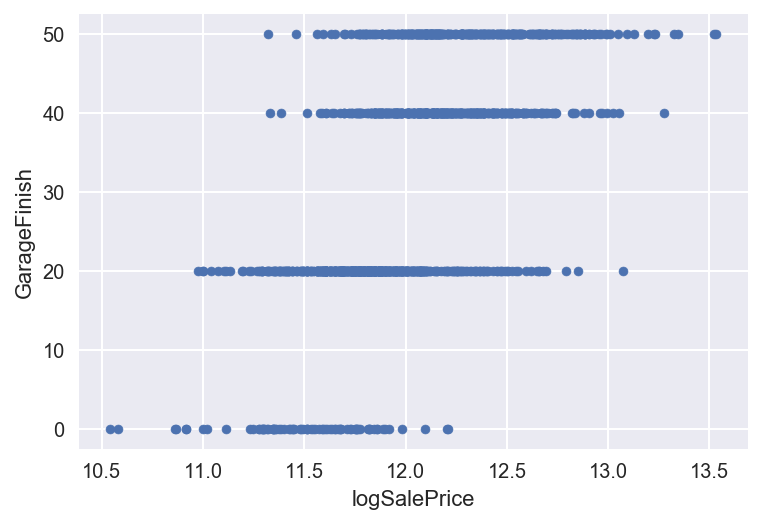

In [115]:
pd.concat([renovate.GarageFinish, house.logSalePrice],axis=1).plot.scatter(x='logSalePrice', y='GarageFinish')

# Yes, unfinished garage is better than no garage.
# ok, now I realised they meant an unfinished interior of the garage.

In [116]:
paved_dict = {'Y': 20, 'P': 10, 'N':0}
renovate['PavedDrive'] = renovate['PavedDrive'].replace(paved_dict)

### Let's try again with updated numeric features

In [117]:
house_renovate = pd.get_dummies(renovate)

Xren_pre2010 = house_renovate[house_renovate.YrSold < 2010].copy()
Xren_2010 = house_renovate[house_renovate.YrSold == 2010].copy()

Xren_pre2010.drop('YrSold',axis=1, inplace=True)
Xren_2010.drop('YrSold',axis=1, inplace=True)

In [118]:
Xs_ren_pre2010 = scaler.fit_transform(Xren_pre2010)
Xs_ren_2010 = scaler.fit_transform(Xren_2010)


l1_ratios = np.linspace(0.1, 1, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs_ren_pre2010, train_res_w)

print optimal_enet.alpha_
print optimal_enet.l1_ratio_


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

14.2774765472
0.9625


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.5s finished


In [119]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs_ren_pre2010, train_res_w, cv=10)

print enet_scores
print np.mean(enet_scores)

[ 0.21592235  0.11029362  0.23166983  0.08411588  0.24004586  0.21189829
  0.13199831  0.0117748   0.15796721  0.19188964]
0.158757578107


In [120]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_ren_pre2010, train_res_w)

print optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_ren_pre2010, train_res_w, cv=10)

print lasso_scores
print np.mean(lasso_scores)

lasso.fit(Xs_ren_pre2010, train_res_w)

lasso_coefs = pd.DataFrame({'variable':Xren_pre2010.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs[lasso.coef_ != 0]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

447.355883174
[ 0.224185    0.08231989  0.24713666  0.0638303   0.25876706  0.20511648
  0.13511712 -0.06196848  0.17268192  0.21252515]
0.153971110293


,abs_coef,coef,variable
22,3003.370003,-3003.370003,RoofMatl_ClyTile
29,2992.185447,2992.185447,RoofMatl_WdShngl
7,2963.873739,2963.873739,KitchenQual
33,2864.493428,2864.493428,Exterior1st_BrkFace
8,2445.844626,2445.844626,Fireplaces
14,2072.253942,2072.253942,PoolQC
17,2052.151057,-2052.151057,RoofStyle_Gable
71,1960.458261,-1960.458261,BsmtFinType1_Unf
35,1402.937633,1402.937633,Exterior1st_CemntBd
102,1318.683467,-1318.683467,MiscFeature_TenC


In [121]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_ren_pre2010, train_res_w)

print optimal_ridge.alpha_

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs_ren_pre2010, train_res_w, cv=10)

print ridge_scores
print np.mean(ridge_scores)


731.680714343
[ 0.21366853  0.11402377  0.22915152  0.0854951   0.23533992  0.2112864
  0.13291303  0.0217036   0.15544025  0.18979717]
0.158881928845


In [122]:
print "Lasso " + str(np.mean(lasso_scores))
print "E-Net " + str(np.mean(enet_scores))
print "Ridge " + str(np.mean(ridge_scores))

Lasso 0.153971110293
E-Net 0.158757578107
Ridge 0.158881928845


In [123]:
best_lasso = Lasso(alpha=optimal_lasso.alpha_)
best_lasso.fit(Xs_ren_pre2010, train_res_w)
best_lasso.score(Xs_ren_2010, test_res)
# this didn't do so well, have I missed something here?

0.16682835670155971

In [124]:
best_enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
best_enet.fit(Xs_ren_pre2010, train_res_w)
best_enet.score(Xs_ren_2010, test_res)


0.16089499598255816

In [125]:
best_ridge = Ridge(alpha=optimal_ridge.alpha_)
best_ridge.fit(Xs_ren_pre2010, train_res_w)
best_ridge.score(Xs_ren_2010, test_res)
# these last two are fairly consistent, even though elastic l1_ratio was closer to 
# l, suggesting more lasso was being used.

0.15985669225876309

In [126]:
best_enet_coef = pd.DataFrame({'variable':Xren_pre2010.columns,
                               'coef': best_enet.coef_,
                               'abs_coef':np.abs(best_enet.coef_)})

best_enet_coef.sort_values('abs_coef', inplace=True, ascending=False)

best_enet_coef[best_enet.coef_ != 0]

,abs_coef,coef,variable
29,2175.922921,2175.922921,RoofMatl_WdShngl
22,2081.989156,-2081.989156,RoofMatl_ClyTile
7,2076.548633,2076.548633,KitchenQual
1,1992.136503,1992.136503,ExterQual
33,1928.616956,1928.616956,Exterior1st_BrkFace
8,1664.002758,1664.002758,Fireplaces
9,1467.221118,1467.221118,FireplaceQu
14,1366.689339,1366.689339,PoolQC
71,1274.578511,-1274.578511,BsmtFinType1_Unf
0,1170.801274,1170.801274,MasVnrArea


In [127]:
# that didn't quite work as well as I'd hoped.  Lasso score took a dive...?

# Based on the coefficients, it appears to be worthwhile changing 
# RoofMatl_ClyTile to RoofMatl_WdShngl.
# Actually the cost of doing so probably wouldn't cover the difference.

# Though the median houseprice is $163,945 so perhaps their cost 
# of labour & material would cover it.

# Sometimes these exercises are unsatisfying in the lack of 
# fantastic predictive value... though based on experience here
# and in the business world, this is fairly commonplace.

# Though assuming I've intpreted this question properly - this component is 
# looking to predict the variance of the fixed attribute only predicted residuals 
# using only the changeables features.  Our previous R^2 in part one was > 90% 
# and a low R^2 here may be an indicator that the variation of the predictive
# residuals cannot be reliably explained by the changeable features alone.
# (assuming I've not taken a huge mis-step somewhere along the lines)

# I would assume a better real world model would be to predict the 
# SalePrice using all features (fixed & changeable) and assess if a particular house/property
# is under or overvalued at sale.


In [128]:
house.SalePrice.describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [129]:
# "It's optional" - KK. Sept 1. 2017

In [130]:
house.SaleCondition.value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [131]:
# we are only concerned about Abnorml and no Abnorml.

# Abnormal = []
# for i in house.SaleCondition:
#    if i == 'Abnorml':
#        Abnormal.append(1)
#    else:
#        Abnormal.append(0)
    

In [132]:
house['Abnormal'] = house.SaleCondition.map(lambda i: 1 if i == 'Abnorml' else 0)

In [133]:
house.Abnormal.value_counts()


0    1354
1      96
Name: Abnormal, dtype: int64

In [134]:
ab_house = house.copy()

In [135]:
ab_house.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

In [136]:
# dropping all Sale related metrics as 'Abnormal' sales is likely to have
# impact on unusual sales results.  Thus picking up on consequences of Abnormal sales
# rather than antecedents/predictors of Abnormal sales before they occur.

ab_house.drop(['SaleType', 'SaleCondition', 'logSalePrice', 'SalePrice'] , axis = 1, inplace = True)

In [137]:
ab_house = pd.get_dummies(ab_house)

In [138]:
ab_house.shape

(1450, 309)

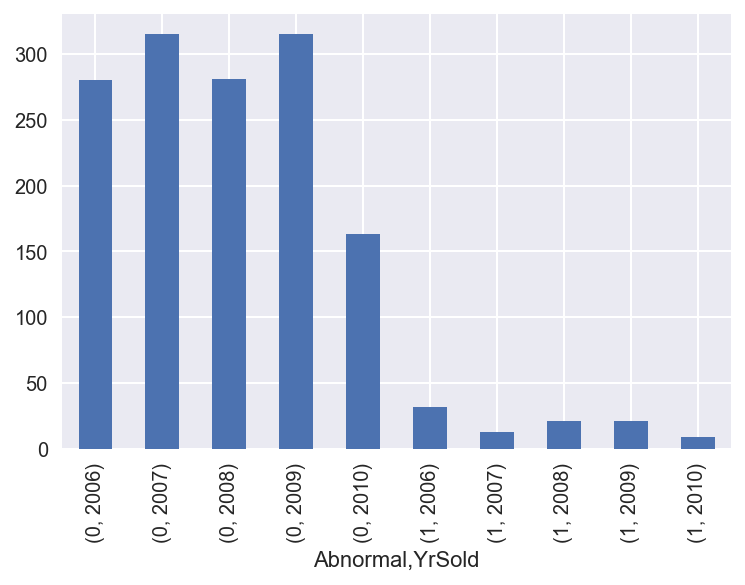

In [139]:
ab_house.groupby(['Abnormal', 'YrSold']).size().plot.bar()

# relatively consistent, train test split. 
# Thought the lwo number of Abornmal cases may be an issue.

In [140]:
Y = ab_house.Abnormal
ab_house.drop('Abnormal', axis=1, inplace=True)

In [141]:
X = scaler.fit_transform(ab_house)

In [142]:
import sklearn.model_selection
(Xtrain, Xtest, Ytrain, Ytest) = sklearn.model_selection.train_test_split(ab_house, Y)

lr = sklearn.linear_model.LogisticRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtest, Ytest)

0.93388429752066116

In [143]:
sorted(zip(lr.coef_[0], ab_house))

[(-0.58338081864285651, 'Fireplaces'),
 (-0.47211665436973493, 'FireplaceQu_Gd'),
 (-0.34312302877883982, 'TotRmsAbvGrd'),
 (-0.34136362966079198, 'HeatingQC_Gd'),
 (-0.31896493292060296, 'Fence_None'),
 (-0.31774855409685637, 'BsmtFinType1_BLQ'),
 (-0.31254130943497727, 'GarageType_Attchd'),
 (-0.31125817529149835, 'MSZoning_RM'),
 (-0.27550381435436411, 'Neighborhood_BrkSide'),
 (-0.26484405174691567, 'CentralAir_N'),
 (-0.25214024890475589, 'HouseStyle_1.5Fin'),
 (-0.25079146658071605, 'Exterior2nd_Wd Sdng'),
 (-0.24072515498067709, 'KitchenQual_Fa'),
 (-0.23730655167819337, 'MasVnrType_None'),
 (-0.22473131780323446, 'Baths_Total'),
 (-0.22155521523318991, 'Exterior1st_BrkFace'),
 (-0.21294752469917297, 'MSSubClass_1.5STORY_FIN'),
 (-0.19812171521154032, 'Neighborhood_CollgCr'),
 (-0.19636575787295987, 'OverallCond'),
 (-0.19612094571995833, 'LandSlope_Gtl'),
 (-0.187353034591099, 'HalfBath'),
 (-0.1673599952053188, 'Exterior2nd_BrkFace'),
 (-0.16168763841488326, 'RoofStyle_Hip'),


In [144]:
import sklearn.dummy
dummy = sklearn.dummy.DummyClassifier(strategy = 'most_frequent')
dummy.fit(Xtrain, Ytrain)
dummy.score(Xtest, Ytest)

0.9366391184573003

In [145]:
predicted = lr.predict(ab_house)
from sklearn.metrics import confusion_matrix


In [146]:
conmat = np.array(confusion_matrix(Y, predicted, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['Abnormal', 'Normal'],
                         columns=['predicted_Abnormal','predicted_Normal'])
confusion

# High proportion of false positive Abnormal results (predicing Abnormal when is actually normal)


,predicted_Abnormal,predicted_Normal
Abnormal,7,89
Normal,2,1352


In [147]:
# I'm assuming an alternative methodology is required to appropriately address this
# based on the class imbalance of Abnormal.

# Perhaps a bagging would also be beneficial.
